### Biblioteki

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from sympy import *
import time
from sklearn.linear_model import LinearRegression
from IPython.display import display
from tqdm.auto import tqdm
import dataframe_image as dfi
from numba import jit

### Definicje

Esytmuję wartość oczekiwaną średnią. Dla n węzłów generuję k trajektorii, po czym uśredniam kwadraty różnic numerycznych rozwiązań na siatce gęstej i rzadkiej w danych węzłach.
* **n** - liczba punktów siatki rzadkiej
* **N** - podział siatki rzadkiej na gęstą -> n*N - liczba punktów siatki gęstej
* **Y_g** - numeryczne rozwiązanie na siatce gęstej
* **Y_r** - numeryczne rozwiązanie na siatce rzadkiej
* **Y_rg** - numeryczne rozwiązanie na siatce gęstej tylko w punktach siatki rzadkiej
* **k** - ilość trajektorii, których normy różnic w węzłach uśredniamy
* **m** - ilość rozważanych ilości węzłów n = 10 * 2 ** i, i=1,2,...,m
* **NORM** - tablica z sumą kwadratów norm k różnych trajektorii w n węzłach (estymator wartości oczekiwanej, k róznych trajektorii jest właśnie po to)
* **MEAN** - 1(*m) tablica z k uśrednionymi po k trajektoriach wartościami NORM
* **ERROR** - 1 tablica z m wartościami max z m tablic MEAN

$$error =  \mathbb{E}\Big[\max_{1\leqslant i \leqslant n} \Big(|Y_{rg}(x_i)-Y_r(x_i)|^2\Big)\Big] \approx \frac{1}{k}\sum_{j=0}^{k}\Big[\max_{1\leqslant i \leqslant n}\Big(|Y^j_{rg}(x_i)-Y^j_r(x_i)|^2\Big)\Big]$$

In [6]:
def mean_error(ERROR, N, k, m, delta, f, g, ksi, q, tau):
    for i in range (1,m):
        n = 10 * 2 ** i 
        NORM = np.zeros(k, dtype=np.float64).astype(np.float64)
        with tqdm(total=k) as pbar:
            for j in range(k):
                Y_r, Y_rg = Euler_Maruyama(n, N, delta, f, g, ksi, q, tau) # listy z numerycznymi rozwiązaniami na siatkach gęstej i rzadkiej w n*N / n węzłach
                NORM[j] = np.max((Y_rg - Y_r)**2) # lista z kwadratami max różnic w węzłach po n węzłach
                pbar.update(1)
            ERROR[i-1] = (n, np.mean(NORM))
            print(ERROR[i-1])

In [7]:
# n - liczba punktów siatki rzadkiej
# N - podział siatki rzadkiej na gęstą
# algorytm oblicza rozwiązanie na siatkach o n i n*N węzłach

def Euler_Maruyama(n, N, delta, f, g, ksi, q, tau): 

    Y_g = np.zeros(q*n*N+1, dtype=np.float64)
    Y_r = np.zeros(q*n+1, dtype=np.float64)
    Y_rg = np.zeros(q*n+1, dtype=np.float64)

    y_0 = ksi(0.0)
    Y_g[0] = y_0
    Y_r[0] = y_0
    Y_rg[0] = y_0
    
    h = float(tau/n) # siatka rzadka
    #h_sqrt = np.sqrt(h)
    
    H = float(h/N)
    H_sqrt = np.sqrt(H)
    
    W1 = 0.0 
    W2 = 0.0 # bieżąca wartość procesu Wienera
    
    temp = int(0)
    for i in range(1, q*n+1):
        for j in range(1, N+1):
            I_d = temp-N*n
            dW = np.random.normal(0, H_sqrt)
            W2 += dW
            if (I_d >= 0):
                Y_g[temp+1] = Y_g[temp] + f(Y_g[temp], Y_g[I_d])*H + g(Y_g[temp], Y_g[I_d])*dW
            else:
                Y_g[temp+1] = Y_g[temp] + f(Y_g[temp], ksi(I_d*H))*H + g(Y_g[temp], ksi(I_d*H))*dW
            temp = int(temp+1)
        Y_rg[i] = Y_g[temp]
        i_d = i-1-n
        W = W2 - W1
        if (i_d >= 0):
            Y_r[i] = Y_r[i-1] + f(Y_r[i-1], Y_r[i_d])*h + g(Y_r[i-1], Y_r[i_d])*W
        else:
            Y_r[i] = Y_r[i-1] + f(Y_r[i-1], ksi(i_d*h))*h + g(Y_r[i-1], ksi(i_d*h))*W
        W1 = W2
    return Y_r, Y_rg
    #return np.max((Y_rg - Y_r)**2)
    #return np.max((Y_g[::N] - Y_r)**2)

### Model proliferacji komórek dla $\rho_0 = \rho_1 = \frac{1}{2}$ oraz $\beta=0.4$

In [2]:
rho_0_1 = 0.5
rho_1_1 = 0.5
beta_1 = 0.4

q_1_ = 10
tau_1_ = 0.3
T_1_ = q_1_*tau_1_


def delta_1_(t):
    return t-tau_1


def f_1_(x, xd):
    return rho_0_1*x + rho_1_1*xd


def g_1_(x, xd):
    return beta_1


def ksi_1_(t):
    return 0.5*tau_1_

In [8]:
ERROR_1 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_1, 100, 1000, 8, delta_1, f_1, g_1, ksi_1, q_1, tau_1)
end = time.time()
print(end - start)

  0%|          | 0/1000 [00:00<?, ?it/s]

(20, 0.006294775155017806)


  0%|          | 0/1000 [00:00<?, ?it/s]

(40, 0.0015225759448844194)


  0%|          | 0/1000 [00:00<?, ?it/s]

(80, 0.00037158019295987046)


  0%|          | 0/1000 [00:00<?, ?it/s]

(160, 9.554355273895446e-05)


  0%|          | 0/1000 [00:00<?, ?it/s]

(320, 2.3382882649353272e-05)


  0%|          | 0/1000 [00:00<?, ?it/s]

(640, 6.4132668202033925e-06)


  0%|          | 0/1000 [00:00<?, ?it/s]

(1280, 1.5813793414970414e-06)
22159.034044742584


In [9]:
ERROR_1

array([(20, 0.006294775155017806), (40, 0.0015225759448844194),
       (80, 0.00037158019295987046), (160, 9.554355273895446e-05),
       (320, 2.3382882649353272e-05), (640, 6.4132668202033925e-06),
       (1280, 1.5813793414970414e-06)], dtype=object)

In [11]:
N_ = []
err = []
for i in ERROR_1:
  N_.append(q_1*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])]),"dferror1_.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])])

,n*q,err,log n*q,log err
1,200,0.006295,2.30103,-2.201020
2,400,0.001523,2.60206,-2.817421
3,800,0.000372,2.90309,-3.429947
4,1600,0.000096,3.20412,-4.019799
5,3200,0.000023,3.50515,-4.631102
6,6400,0.000006,3.80618,-5.192921
7,12800,0.000002,4.10721,-5.800964


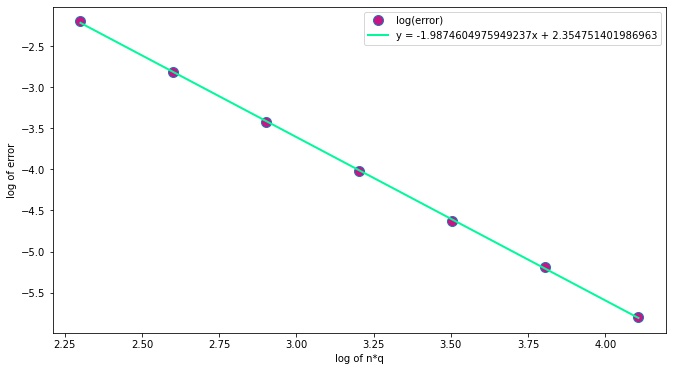

In [14]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n*q'],df['log err'])

mn=np.min(np.log10(N_))
mx=np.max(np.log10(N_))

X = np.linspace(mn,mx,500)

plt.figure(figsize=(11,6))
plt.plot(df['log n*q'],df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X+intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror1_.png')
plt.show()

In [17]:
X = np.linspace(0, tau_1*q_1, q_1*500+1)
#Y = np.linspace(-tau, -0.05, 10)

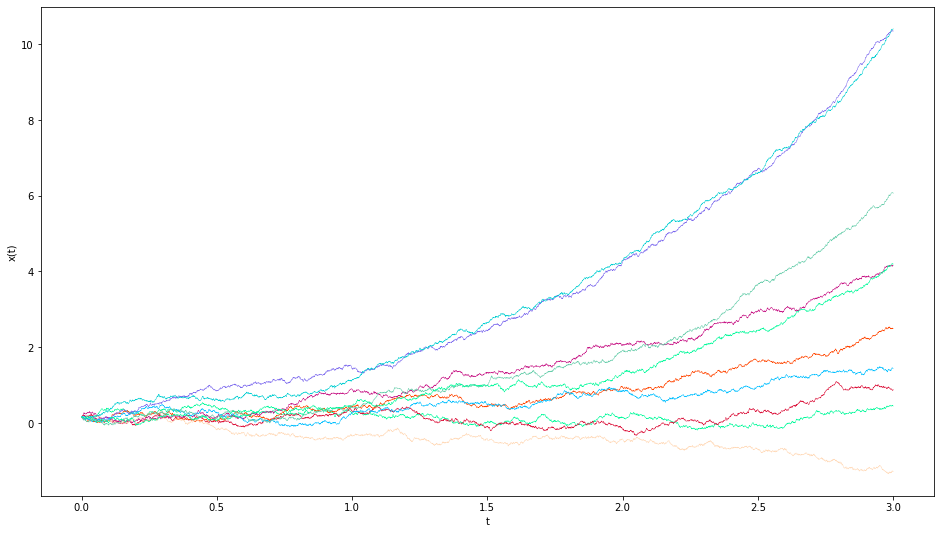

In [18]:
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama(500, 100, delta_1, f_1, g_1, ksi_1, q_1, tau_1)
    plt.plot(X,  G, color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot1_.png')
plt.show()

### Model proliferacji komórek dla $\rho_0 = 0.6, \rho_1 = 0.4$ oraz $\beta(t) = 0.2X(t)$

In [9]:
rho_0_2 = 0.6
rho_1_2 = 0.4
beta_2 = 0.2

q_2_ = 10
tau_2_ = 0.4
T_2_ = q_2_*tau_2_


def delta_2_(t):
    return t-tau_2


def f_2_(x, xd):
    return rho_0_2*x + rho_1_2*xd


def g_2_(x, xd):
    return beta_2*x


def ksi_2_(t):
    return 0.7*tau_2_

In [10]:
ERROR_2 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_2, 100, 1000, 8, delta_2, f_2, g_2, ksi_2, q_2, tau_2)
end = time.time()
print(end - start)

  0%|          | 0/1000 [00:00<?, ?it/s]

(20, 0.10566185694830607)


  0%|          | 0/1000 [00:00<?, ?it/s]

(40, 0.029174212343961416)


  0%|          | 0/1000 [00:00<?, ?it/s]

(80, 0.0072297631024184775)


  0%|          | 0/1000 [00:00<?, ?it/s]

(160, 0.0022229575145291474)


  0%|          | 0/1000 [00:00<?, ?it/s]

(320, 0.0008176933811160837)


  0%|          | 0/1000 [00:00<?, ?it/s]

(640, 0.0003011109890751714)


  0%|          | 0/1000 [00:00<?, ?it/s]

(1280, 0.0001376495529468269)
22190.892646312714


In [11]:
ERROR_2

array([(20, 0.10566185694830607), (40, 0.029174212343961416),
       (80, 0.0072297631024184775), (160, 0.0022229575145291474),
       (320, 0.0008176933811160837), (640, 0.0003011109890751714),
       (1280, 0.0001376495529468269)], dtype=object)

In [12]:
N_ = []
err = []
for i in ERROR_2:
  N_.append(q_2*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])]),"dferror2_.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])])

,n*q,err,log n*q,log err
1,200,0.105662,2.30103,-0.976082
2,400,0.029174,2.60206,-1.535001
3,800,0.007230,2.90309,-2.140876
4,1600,0.002223,3.20412,-2.653069
5,3200,0.000818,3.50515,-3.087410
6,6400,0.000301,3.80618,-3.521273
7,12800,0.000138,4.10721,-3.861225


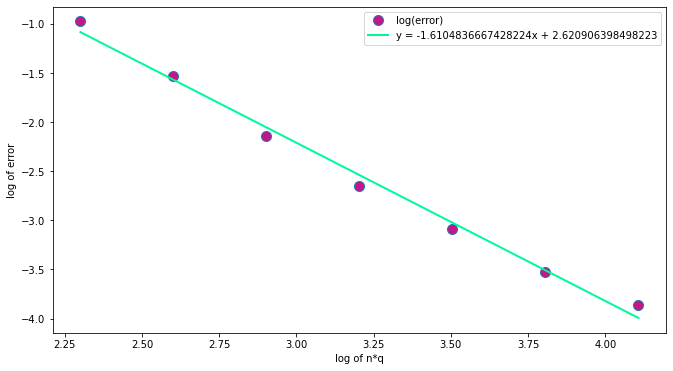

In [13]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n*q'],df['log err'])

mn=np.min(np.log10(N_))
mx=np.max(np.log10(N_))

X = np.linspace(mn,mx,500)

plt.figure(figsize=(11,6))
plt.plot(df['log n*q'],df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X+intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror2_.png')
plt.show()

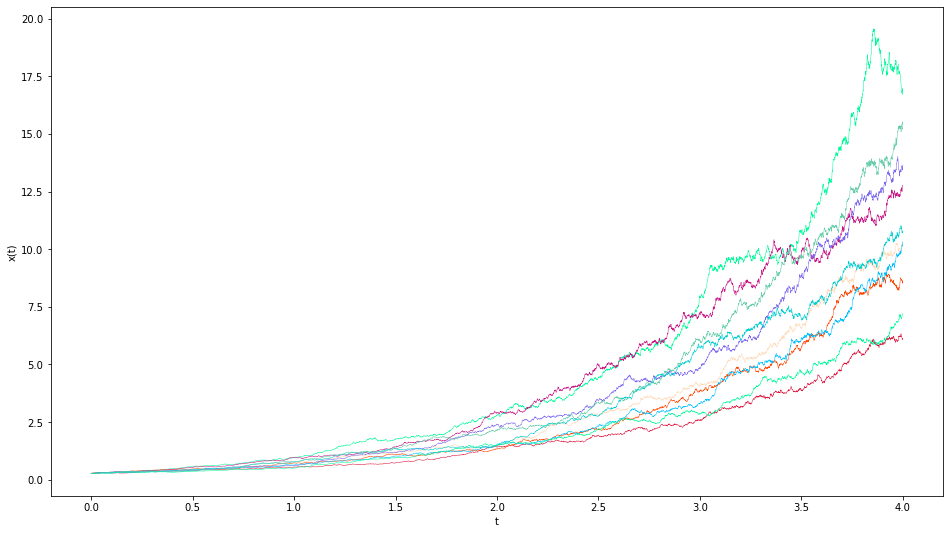

In [14]:
X = np.linspace(0, tau_2*q_2, q_2*500+1)
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama(500, 100, delta_2, f_2, g_2, ksi_2, q_2, tau_2)
    plt.plot(X,  G, color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot2_.png')
plt.show()

### Model populacji jednopłciowych

In [17]:
rho_0_3 = -0.7
rho_1_3 = 0.6
beta_3 = 1.

q_3_ = 10
tau_3_ = 0.5
T_3_ = q_3_*tau_3_


def delta_3_(t):
    return t-tau_3


def f_3_(x, xd):
    return rho_0_3*x + rho_1_3*xd


def g_3_(x, xd):
    return beta_3


def ksi_3_(t):
    return np.sqrt(np.abs(t))

In [18]:
ERROR_3 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_3, 100, 1000, 8, delta_3, f_3, g_3, ksi_3, q_3, tau_3)
end = time.time()
print(end - start)

  0%|          | 0/1000 [00:00<?, ?it/s]

(20, 0.0002549855674062727)


  0%|          | 0/1000 [00:00<?, ?it/s]

(40, 6.682772876242774e-05)


  0%|          | 0/1000 [00:00<?, ?it/s]

(80, 1.7321921363390384e-05)


  0%|          | 0/1000 [00:00<?, ?it/s]

(160, 4.351966861351209e-06)


  0%|          | 0/1000 [00:00<?, ?it/s]

(320, 1.1046826126638807e-06)


  0%|          | 0/1000 [00:00<?, ?it/s]

(640, 2.803485880604078e-07)


  0%|          | 0/1000 [00:00<?, ?it/s]

(1280, 6.995705293910752e-08)
22711.634145736694


In [19]:
ERROR_3

array([(20, 0.0002549855674062727), (40, 6.682772876242774e-05),
       (80, 1.7321921363390384e-05), (160, 4.351966861351209e-06),
       (320, 1.1046826126638807e-06), (640, 2.803485880604078e-07),
       (1280, 6.995705293910752e-08)], dtype=object)

In [20]:
N_ = []
err = []
for i in ERROR_3:
  N_.append(q_3*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])]),"dferror3_.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])])

,n*q,err,log n*q,log err
1,200,2.549856e-04,2.30103,-3.593484
2,400,6.682773e-05,2.60206,-4.175043
3,800,1.732192e-05,2.90309,-4.761404
4,1600,4.351967e-06,3.20412,-5.361314
5,3200,1.104683e-06,3.50515,-5.956762
6,6400,2.803486e-07,3.80618,-6.552302
7,12800,6.995705e-08,4.10721,-7.155168


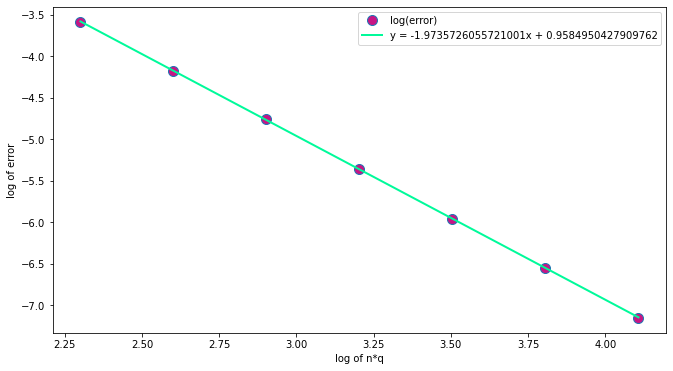

In [21]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n*q'],df['log err'])

mn=np.min(np.log10(N_))
mx=np.max(np.log10(N_))

X = np.linspace(mn,mx,500)

plt.figure(figsize=(11,6))
plt.plot(df['log n*q'],df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X+intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror3_.png')
plt.show()

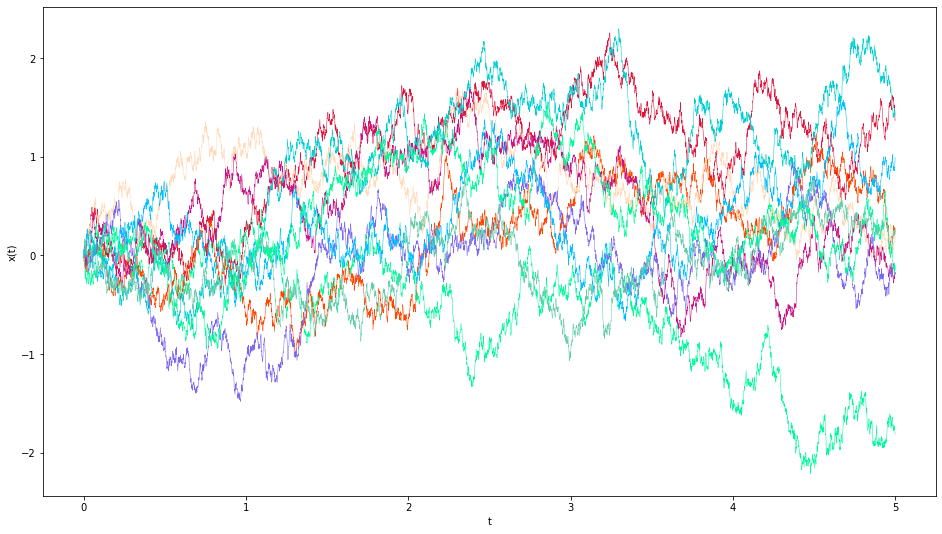

In [22]:
X = np.linspace(0, tau_3*q_3, q_3*500+1)
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama(500, 100, delta_3, f_3, g_3, ksi_3, q_3, tau_3)
    plt.plot(X,  G, color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot3_.png')
plt.show()

### Model CIR z opóźnieniem dla $\eta = 1$ ze stałym warunkiem początkowym $\xi(t) = \frac{1}{2}\tau$

In [3]:
lam =  0.4363
mu =  0.0613
sigma = 0.1491
eta = 1.0

q = 10
tau = 0.3
T = q*tau


def delta_1(t):
    return t-tau


def f_1(x, xd):
    return lam*(mu-x)


def g_1(x, xd):
    return np.sqrt(np.abs(x))*sigma*np.abs(xd)**eta


def ksi_1(t):
    return 0.5*tau

In [133]:
ERROR_1 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_1, 100, 1000, 8, delta_1, f_1, g_1, ksi_1)
end = time.time()
print(end - start)

  0%|          | 0/1000 [00:00<?, ?it/s]

(20, 1.8599233565414776e-08)


  0%|          | 0/1000 [00:00<?, ?it/s]

(40, 5.48429804066686e-09)


  0%|          | 0/1000 [00:00<?, ?it/s]

(80, 1.7272622230061485e-09)


  0%|          | 0/1000 [00:00<?, ?it/s]

(160, 6.300734258697285e-10)


  0%|          | 0/1000 [00:00<?, ?it/s]

(320, 2.50835600902331e-10)


  0%|          | 0/1000 [00:00<?, ?it/s]

(640, 1.0573019178456545e-10)


  0%|          | 0/1000 [00:00<?, ?it/s]

(1280, 5.153910029586162e-11)
38116.78869128227


In [4]:
ERROR_1

array([[20, 1.8599233565414776e-08],
       [40, 5.48429804066686e-09],
       [80, 1.7272622230061485e-09],
       [160, 6.300734258697285e-10],
       [320, 2.50835600902331e-10],
       [640, 1.0573019178456545e-10],
       [1280, 5.153910029586162e-11]], dtype=object)

In [5]:
N_ = []
err = []
for i in ERROR_1:
  N_.append(10*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])]),"dferror1.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])])

,n*q,err,log n*q,log err
1,200,1.859923e-08,2.30103,-7.730505
2,400,5.484298e-09,2.60206,-8.260879
3,800,1.727262e-09,2.90309,-8.762642
4,1600,6.300734e-10,3.20412,-9.200609
5,3200,2.508356e-10,3.50515,-9.600611
6,6400,1.057302e-10,3.80618,-9.975801
7,12800,5.153910e-11,4.10721,-10.287863


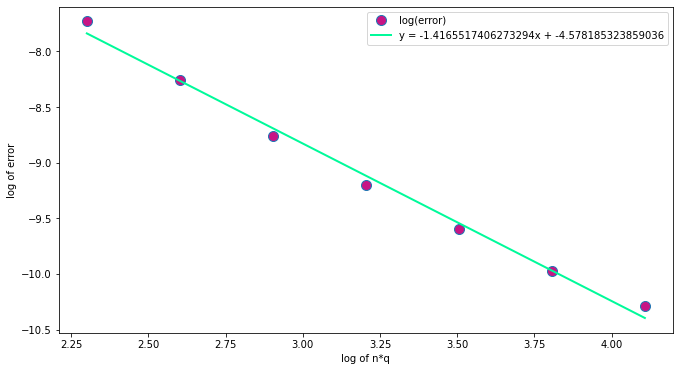

In [24]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n'],df['log err'])

min_ = np.min(np.log10(N_))
max_ = np.max(np.log10(N_))
X = np.linspace(min_, max_, 500)

plt.figure(figsize=(11,6))
plt.plot(df['log n'], df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X + intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror1.png')
plt.show()

In [165]:
X = np.linspace(0, tau*q, q*500+1)
Y = np.linspace(-tau, -0.03, 10)

In [166]:
P = np.array(list(map(ksi_1, Y)))
P

array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15])

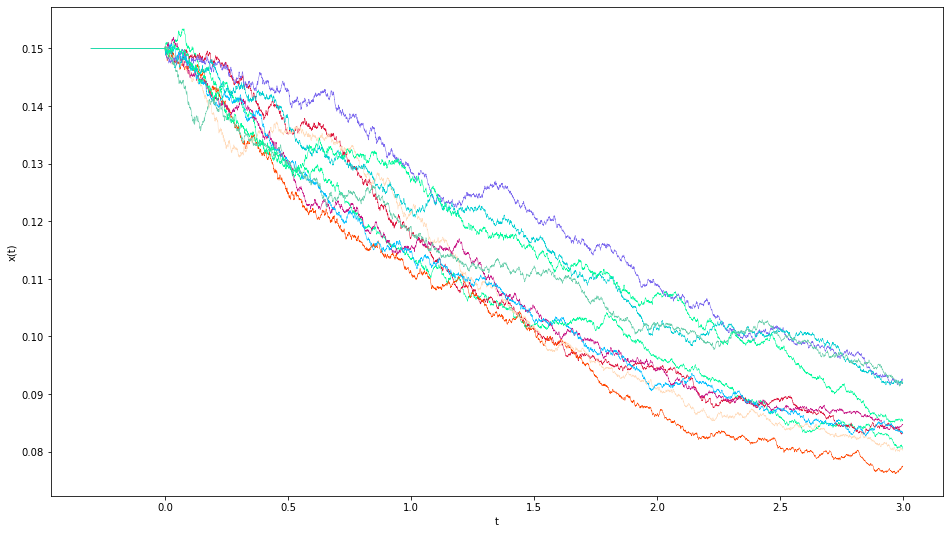

In [186]:
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama_PP(500, 100, delta_1, f_1, g_1, ksi_1)
    plt.plot(np.concatenate((Y, X), axis=None), np.concatenate((P, G), axis=None), color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot1.png')
plt.show()

### Model CIR dla $\eta = 1$ z  warunkiem początkowym $\sqrt{|t|}$

In [31]:
lam =  0.4363
mu =  0.0613
sigma = 0.1491
eta = 1.0

q = 5
tau = 0.5
T = q*tau

def delta_2(t):
    return float(t-tau)

def f_2(x, xd):
    return float(lam*(mu-x))

def g_2(x, xd):
    return float(np.sqrt(np.abs(x))*sigma*np.abs(xd)**eta)

def ksi_2(t):
    return np.sqrt(np.abs(t))

In [ ]:
ERROR_2 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_2, 100, 1000, 7, delta_2, f_2, g_2, ksi_2)
end = time.time()
print(end - start)

In [7]:
ERROR_2

[(20, 2.8185266002370254e-07),
 (40, 1.1582899540598017e-07),
 (80, 4.329794832866287e-08),
 (160, 1.9252402635943683e-08),
 (320, 8.861027596027031e-09),
 (640, 4.181364660977394e-09)]

In [8]:
N_ = []
err = []
for i in ERROR_2:
  N_.append(5*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6])]),"dferror2.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6])])

,n*q,err,log n*q,log err
1,100,2.818527e-07,2.00000,-6.549978
2,200,1.158290e-07,2.30103,-6.936183
3,400,4.329795e-08,2.60206,-7.363533
4,800,1.925240e-08,2.90309,-7.715515
5,1600,8.861028e-09,3.20412,-8.052516
6,3200,4.181365e-09,3.50515,-8.378682


In [8]:
N_ = []
err = []
for i in ERROR_2:
  N_.append(5*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6])]),"dferror2.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6])])

,n*q,err,log n*q,log err
1,100,2.818527e-07,2.00000,-6.549978
2,200,1.158290e-07,2.30103,-6.936183
3,400,4.329795e-08,2.60206,-7.363533
4,800,1.925240e-08,2.90309,-7.715515
5,1600,8.861028e-09,3.20412,-8.052516
6,3200,4.181365e-09,3.50515,-8.378682


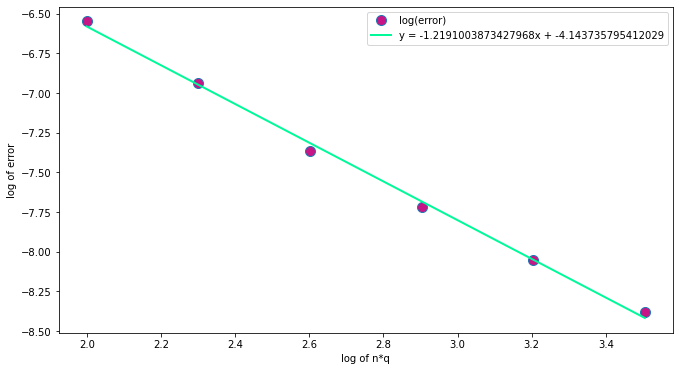

In [28]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n'],df['log err'])

mn=np.min(np.log10(N_))
mx=np.max(np.log10(N_))

X = np.linspace(mn,mx,500)

plt.figure(figsize=(11,6))
plt.plot(df['log n'],df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X+intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror2.png')
plt.show()

In [32]:
X = np.linspace(0, tau*q, q*500+1)

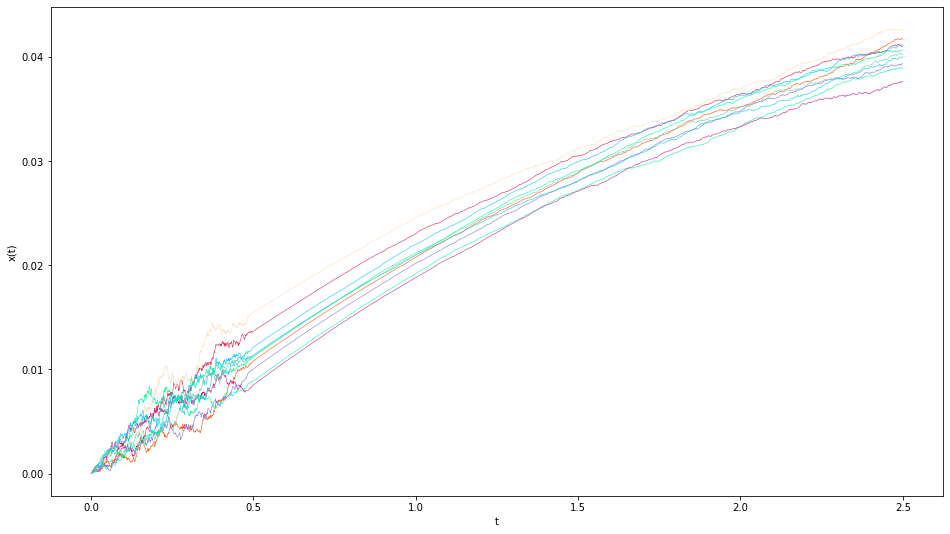

In [33]:
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama_PP(500, 100, delta_2, f_2, g_2, ksi_2)
    plt.plot(X,  G, color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot2.png')
plt.show()

### Stochastycznie zaburzony neoklasyczny model wzrostu z opóźnionym argumentem czasowym

In [8]:
alpha = 0.0011
beta = 0.02
d = 1.0
q = 10
tau = 0.3
T = q*tau
sigma = 0.447
eta = 2.0

def delta_3(t):
    return t-tau

def f_3(x, xd):
    return (-1)*alpha*x + beta*xd**eta*exp((-1)*d*xd)

def g_3(x, xd):
    return sigma*x

def ksi_3(t):
    return 0.2

In [ ]:
ERROR_3 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_3, 20, 1000, 6, delta_3, f_3, g_3, ksi_3)
end = time.time()
print(end - start)

In [11]:
ERROR_3

[(20, 0.004281980347348278),
 (40, 0.002596387353785534),
 (80, 0.0011668120532983062),
 (160, 0.0010568959450081219),
 (320, 0.00026378741336233457)]

In [14]:
N_ = []
err = []
for i in ERROR_3:
  N_.append(q*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5])]),"dferror3.png")
df.set_index([pd.Index([1, 2, 3, 4, 5])])

,n*q,err,log n*q,log err
1,200,0.004282,2.30103,-2.368355
2,400,0.002596,2.60206,-2.585631
3,800,0.001167,2.90309,-2.932999
4,1600,0.001057,3.20412,-2.975968
5,3200,0.000264,3.50515,-3.578746


In [14]:
X = np.linspace(0, tau*q, q*50+1)
Y = np.linspace(-tau, -0.03, 10)

In [15]:
P = np.array(list(map(ksi_3, Y)))
P

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

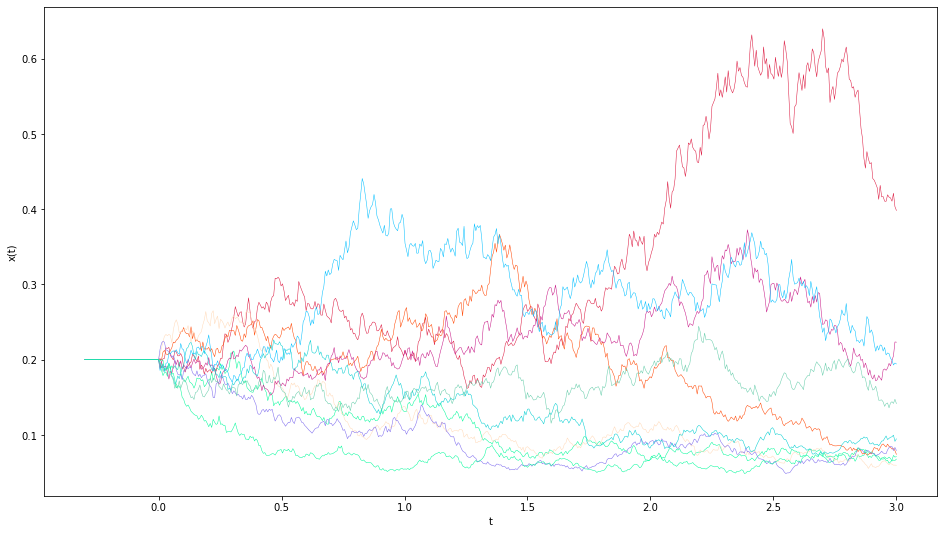

In [16]:
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama_PP(50, 100, delta_3, f_3, g_3, ksi_3)
    plt.plot(np.concatenate((Y, X), axis=None), np.concatenate((P, G), axis=None), color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot3.png')
plt.show()

### Model dla $\eta = \frac{1}{2}$ ze stałym warunkiem początkowym $\xi(t) = 0.6\cdot\tau$

In [ ]:
lam =  0.4363
mu =  0.0613
sigma = 0.1491
eta = 0.5

q = 10
tau = 0.4
T = q*tau


def delta_5(t):
    return t-tau


def f_5(x, xd):
    return mu*xd*x


def g_5(x, xd):
    return sigma*xd*x


def ksi_5(t):
    return 0.6*tau

In [ ]:
ERROR_4 = np.empty(7, dtype=object)
start = time.time()
mean_error(ERROR_4, 100, 1000, 8, delta_4, f_4, g_4, ksi_4)
end = time.time()
print(end - start)

In [2]:
ERROR_4

[(20, 4.212616436341842e-07),
 (40, 1.605038685664073e-07),
 (80, 7.080472884125384e-08),
 (160, 3.3450538429834325e-08),
 (320, 1.5948476739781802e-08),
 (640, 8.30108665296296e-09),
 (1280, 3.867371206273643e-09)]

In [19]:
N_ = []
err = []
for i in ERROR_4:
  N_.append(q*i[0])
  err.append(i[1])
d = {'n*q':N_, 'err':err, 'log n*q':np.log10(N_), 'log err':np.log10(err)}

import pandas as pd
df = pd.DataFrame(d)
dfi.export(df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])]),"dferror4.png")
df.set_index([pd.Index([1, 2, 3, 4, 5, 6, 7])])

,n*q,err,log n*q,log err
1,200,4.212616e-07,2.30103,-6.375448
2,400,1.605039e-07,2.60206,-6.794514
3,800,7.080473e-08,2.90309,-7.149938
4,1600,3.345054e-08,3.20412,-7.475597
5,3200,1.594848e-08,3.50515,-7.797281
6,6400,8.301087e-09,3.80618,-8.080865
7,12800,3.867371e-09,4.10721,-8.412584


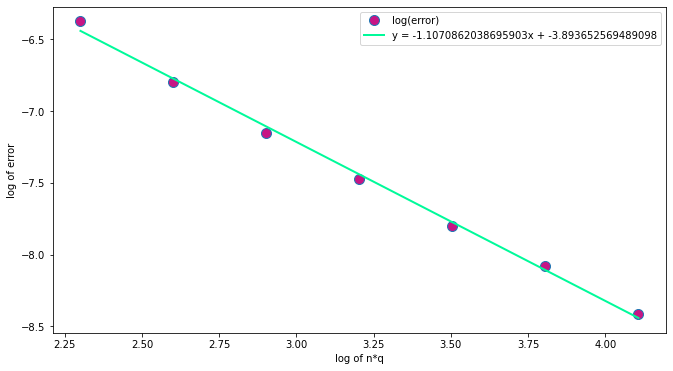

In [20]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log n*q'],df['log err'])

mn=np.min(np.log10(N_))
mx=np.max(np.log10(N_))

X = np.linspace(mn,mx,500)

plt.figure(figsize=(11,6))
plt.plot(df['log n*q'],df['log err'], 'o', markersize=10, markerfacecolor='mediumvioletred', label='log(error)')
plt.plot(X, slope*X+intercept, color='#00fa9a', linewidth='2', label='y = '+str(slope)+'x + '+str(intercept))
plt.xlabel('log of n*q')
plt.ylabel('log of error')
plt.legend()
plt.savefig('slopeerror4.png')
plt.show()

In [ ]:
X = np.linspace(0, tau*q, q*50+1)
Y = np.linspace(-tau, -0.04, 10)

In [ ]:
P = np.array(list(map(ksi_4, Y)))
P

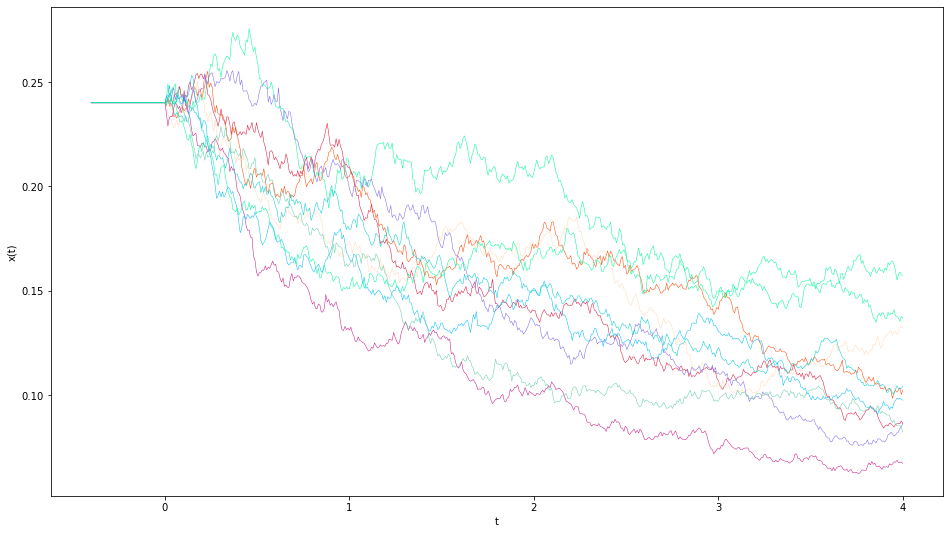

In [24]:
plt.figure(figsize=(16,9))
colors = ['#00fa9a', '#DC143C', '#FF4500', '#FFDAB9', '#C71585', '#7B68EE', '#00BFFF', '#00CED1', '#66CDAA', '#00FA9A']
for i in range(10):
    R, G = Euler_Maruyama_PP(50, 100, delta_4, f_4, g_4, ksi_4)
    plt.plot(np.concatenate((Y, X), axis=None), np.concatenate((P, G), axis=None), color=colors[i], linewidth='0.5')
plt.xlabel('t')
plt.ylabel('x(t)')
#plt.legend()
plt.savefig('plot4.png')
plt.show()